In [2]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import awkward as ak
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

In [3]:
import uproot
### Energy = 0.15 GeV
root_file1 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF1.root")
root_file2 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF2.root")
tree1 = root_file1["Samples"]
tree2 = root_file2["Samples"]
arrays1 = tree1.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
arrays2 = tree2.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays1["samples"])
X_real = X_real/np.max(X_real, axis = 1).reshape(200000,1)
y_real = ak.to_numpy(arrays1["ysamples"])
X_noise = ak.to_numpy(arrays2["samplesNoise"])
X_noise = X_noise/np.max(X_noise, axis = 1).reshape(200000,1)
y_noise = ak.to_numpy(arrays2["ysamplesNoise"])
X_freal = np.abs(fft(X_real))/5.
X_fnoise = np.abs(fft(X_noise))/5.

print(X_real) 
print("Printing y_real")
print(y_real)

data1 = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
data2 = np.concatenate([X_freal, X_fnoise])
labels = np.concatenate([y_real, y_noise])


# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data1))
data1 = data1[shuffle_indices]
data2 = data2[shuffle_indices]
labels = labels[shuffle_indices]

[[-2.18991428 -1.33758012 -0.16379419 ...  0.97133729  0.38098346
  -1.97539871]
 [-0.02620282  0.3494965   0.54694886 ...  0.55314748  0.19741884
  -0.15557223]
 [ 0.70501369  0.95452037  1.         ...  0.82044019  0.71309163
   0.61413221]
 ...
 [-0.03224206 -0.11911494  0.25985249 ...  0.45905995  0.7742844
   1.        ]
 [ 0.42559843  0.71037992  0.30653368 ...  0.96303223  1.
   0.64932407]
 [-0.13804387  0.03573051 -0.07850811 ...  0.81263918  0.81864257
   0.44620173]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [4]:
import awkward as ak

num_events_data = ak.num(data1, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data1, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
valid_size = train_size + int(0.1 * num_events_data)
train_data1 = data1[:train_size]
train_data2 = data2[:train_size]
train_labels = labels[:train_size]
valid_data1 = data1[train_size:valid_size]
valid_data2 = data2[train_size:valid_size]
valid_labels = labels[train_size:valid_size]
test_data1 = data1[valid_size:]
test_data2 = data2[valid_size:]
test_labels = labels[valid_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : validation data: {len(data1)} : {len(train_data1)} : {len(test_data1)} : {len(valid_data1)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 280000
number of elements in data : training data : test data : validation data: 400000 : 280000 : 80000 : 40000


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [6]:
train_data1 = train_data1.reshape((train_data1.shape[0], train_data1.shape[1], 1))
test_data1 = test_data1.reshape((test_data1.shape[0], test_data1.shape[1], 1))
valid_data1 = valid_data1.reshape((valid_data1.shape[0], valid_data1.shape[1], 1))
train_data2 = train_data2.reshape((train_data2.shape[0], train_data2.shape[1], 1))
test_data2 = test_data2.reshape((test_data2.shape[0], test_data2.shape[1], 1))
valid_data2 = valid_data2.reshape((valid_data2.shape[0], valid_data2.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))
valid_labels = valid_labels.reshape((valid_labels.shape[0], 1))

In [7]:
train_data1 = torch.tensor(train_data1, dtype =torch.float).to(device)
test_data1 = torch.tensor(test_data1, dtype =torch.float).to(device)
valid_data1 = torch.tensor(valid_data1, dtype =torch.float).to(device)
train_data2 = torch.tensor(train_data2, dtype =torch.float).to(device)
test_data2 = torch.tensor(test_data2, dtype =torch.float).to(device)
valid_data2 = torch.tensor(valid_data2, dtype =torch.float).to(device)
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)
valid_labels = torch.tensor(valid_labels, dtype =torch.float).to(device)

In [8]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data1: torch.tensor,
        data2: torch.tensor,         
        lebel: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data1 = data1
        self.data2 = data2
        self.lebel = lebel

        print("data size = {}".format(data1.size()))
        print("data size = {}".format(data2.size()))
        print("target size = {}".format(lebel.size()))
            

    def __len__(self):
        
        return self.data1.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data1 = self.data1[index]
        data2 = self.data2[index]
        lebel = self.lebel[index]
        return data1, data2, lebel

In [9]:
training_class = ClassifierDataset(
    data1 = train_data1,
    data2 = train_data2,
    lebel = train_labels)

data size = torch.Size([280000, 10, 1])
data size = torch.Size([280000, 10, 1])
target size = torch.Size([280000, 1])


In [10]:
testing_class = ClassifierDataset(
    data1 = test_data1,
    data2 = test_data2,
    lebel = test_labels)

data size = torch.Size([80000, 10, 1])
data size = torch.Size([80000, 10, 1])
target size = torch.Size([80000, 1])


In [11]:
validing_class = ClassifierDataset(
    data1 = valid_data1,
    data2 = valid_data2,
    lebel = valid_labels)

data size = torch.Size([40000, 10, 1])
data size = torch.Size([40000, 10, 1])
target size = torch.Size([40000, 1])


In [12]:
# Load the training data
training_dataloader = DataLoader(training_class, batch_size= 128)
# Load the testing data
testing_dataloader = DataLoader(testing_class, batch_size= 128)
# Load the validing data
validing_dataloader = DataLoader(validing_class, batch_size= 128)

In [13]:
class Classification_RNN(nn.Module):
    def __init__(self, input_size, hidden_dim1, hidden_dim2):
        super().__init__()
        self.rnn_1 = nn.LSTM(input_size, hidden_dim1, 1, bidirectional= True, batch_first= True)
        self.rnn_2 = nn.LSTM(2*hidden_dim1, hidden_dim2, 1, bidirectional= True, batch_first= True)
        self.fc1 = nn.Linear(2*hidden_dim2, 1)
        
        self.rnn_3 = nn.LSTM(input_size, hidden_dim1, 1, bidirectional= True, batch_first= True)
        self.rnn_4 = nn.LSTM(2*hidden_dim1, hidden_dim2, 1, bidirectional= True, batch_first= True)
        self.fc2 = nn.Linear(2*hidden_dim2, 1)
        
        self.fc = nn.Linear(20, input_size)
        self.activation = nn.Sigmoid()
        
    def forward(self, src1, src2):
        #print("Intial size",src1.size())
        output1, _ = self.rnn_1(src1)
        #print("rnn_1 size",output1.size())
        output1, _ = self.rnn_2(output1)
        #print("rnn_2 size",output1.size())
        final_output1 = self.fc1(output1)
        final_output1 = self.activation(final_output1)
        final_output1 = final_output1.reshape((final_output1.shape[0], final_output1.shape[1]))
        #final_output1 = torch.squeeze(final_output1)
        #print("flatten size", final_output1.size())
        
        #print("Intial size",src2.size())
        output2, _ = self.rnn_3(src2)
        #print("rnn_1 size",output2.size())
        output2, _ = self.rnn_4(output2)
        #print("rnn_2 size",output2.size())
        final_output2 = self.fc2(output2)
        final_output2 = self.activation(final_output2)
        final_output2 = final_output2.reshape((final_output2.shape[0], final_output2.shape[1]))
        #print("flatten size", final_output2.size())        
        
        final_output = torch.cat([final_output1, final_output2], 1)
        #print("flatten size", final_output.size())
        
        final_output = self.fc(final_output)
        #print("fc2 size", final_output.size())
        final_output = self.activation(final_output)
        
        return final_output

In [14]:
def create_model():
    input_size = 1
    hidden_dim1 = 16
    hidden_dim2 = 32
 
    model = Classification_RNN(input_size, hidden_dim1, hidden_dim2)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
 
    return model, optimizer, criterion

In [15]:
def train(training_dataloader, validing_dataloader, epochs = 10):
    
    model, optimizer, criterion = create_model()
    
    for epoch in range(1, epochs + 1):
        training_loss = []
        model.train()
        
        for i, (data1, data2, labels) in enumerate(training_dataloader):
            
            optimizer.zero_grad()

            output = model(data1, data2)

            loss = criterion(output, labels)
                        
            loss.backward()
            
            optimizer.step()
 
            training_loss.append(loss.item())
        
        print(f"At epoch {epoch} mean training loss is {torch.mean(torch.FloatTensor(training_loss))}")
        
        with torch.no_grad():
        
            model.eval()
            
            validation_loss = []
            
            for i, (data1, data2, labels) in enumerate(validing_dataloader):
            
                output = model(data1, data2)
                
                loss = criterion(output, labels)
                
                validation_loss.append(loss.item())
            
            print(f"At epoch {epoch} mean validation loss is {torch.mean(torch.FloatTensor(validation_loss))}")
             
    return model

In [17]:
model = train(training_dataloader, validing_dataloader, epochs = 20)

At epoch 1 mean training loss is 0.5662934184074402
At epoch 1 mean validation loss is 0.508623480796814
At epoch 2 mean training loss is 0.5059785842895508
At epoch 2 mean validation loss is 0.5020571351051331
At epoch 3 mean training loss is 0.502277672290802
At epoch 3 mean validation loss is 0.4998635947704315
At epoch 4 mean training loss is 0.5002466440200806
At epoch 4 mean validation loss is 0.49658048152923584
At epoch 5 mean training loss is 0.4984606206417084
At epoch 5 mean validation loss is 0.49363845586776733
At epoch 6 mean training loss is 0.4969156086444855
At epoch 6 mean validation loss is 0.4920838177204132
At epoch 7 mean training loss is 0.49559029936790466
At epoch 7 mean validation loss is 0.4910024404525757
At epoch 8 mean training loss is 0.4944038987159729
At epoch 8 mean validation loss is 0.4899217486381531
At epoch 9 mean training loss is 0.4934476912021637
At epoch 9 mean validation loss is 0.48911604285240173
At epoch 10 mean training loss is 0.49274066

In [18]:
with torch.no_grad():
    model.eval()
    prediction = ()
    target = ()        
    for i, (data1, data2, labels) in enumerate(testing_dataloader):
        #print(data1[1].shape, data2.shape)
        #data1 = data1[1].reshape((1,10,1))
        #data2 = data2[1].reshape((1,10,1))
        #print(f"Step No. ---> {i}")
        output = model(data1, data2)        
        prediction += (output, )
        target += (labels, )

In [19]:
testing_hat = torch.cat(prediction)
testing_hat.size()
testing_org = torch.cat(target)
testing_org.size()
y_test = testing_org.data.cpu().numpy()
predictions = testing_hat.data.cpu().numpy()

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [0. 0. 1. ... 1. 1. 0.]
[[0.7080885 ]
 [0.4697894 ]
 [0.8258975 ]
 ...
 [0.03743113]
 [0.05133811]
 [0.459999  ]]
[[0.8829384 ]
 [0.68441445]
 [0.40432242]
 ...
 [0.8672291 ]
 [0.89000946]
 [0.24766873]]


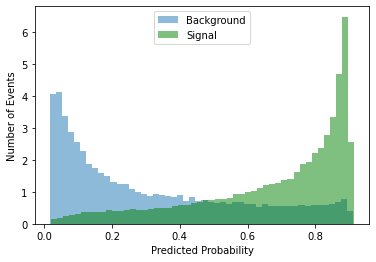

In [60]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Freq_Case1.png")
plt.show()

In [52]:
y_test

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [53]:
predictions

array([[0.7080885 ],
       [0.4697894 ],
       [0.8829384 ],
       ...,
       [0.89000946],
       [0.24766873],
       [0.459999  ]], dtype=float32)

In [61]:
file = uproot.recreate("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Freq_SigBkgCase1.root")

In [62]:
file

<WritableDirectory '/' at 0x7fe7a755ef40>

In [63]:
file['tree'] = { 
                    "True" : y_test,
                    "Prediction" : predictions
    }

In [64]:
file.close()

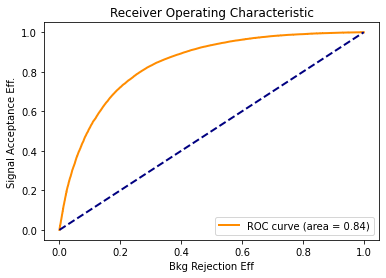

In [59]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Bkg Rejection Eff')
plt.ylabel('Signal Acceptance Eff.')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Freq_Case1_ROC.png")
plt.show()

In [29]:
target = torch.from_numpy(y_test.flatten())
pred = torch.from_numpy(predictions.flatten())

In [30]:
from torchmetrics.classification import BinaryConfusionMatrix

In [31]:
metric = BinaryConfusionMatrix(threshold=0.7, normalize = 'true')(pred, target)
metric

tensor([[0.8743, 0.1257],
        [0.4172, 0.5828]])

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
import uproot
from scipy.stats import norm
from scipy.optimize import curve_fit

In [33]:
num_samples=10
xmin = 0
xmax = 10
bdt_score_min = 0.7
events_to_read = -1

In [45]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * norm.pdf(x, mean, stddev)

In [34]:
def plot_timesamples(ax, time, emsignal_list, legTitle):
    #fig, ax = plt.subplots()
    #for i, emsignal in enumerate(emsignal_list):
    ax.plot(time, emsignal_list, label=f'{legTitle}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
   
    ax.legend()

In [35]:
# Open the ROOT file
#root_file = uproot.open(f"/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree.root")
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree_alcareco.root")

# Access the tree containing the data
tree = root_file["timeSample/EventTreeEle"]

tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eleE                 | double                   | AsDtype('>f8')
elePt                | double                   | AsDtype('>f8')
eleEta               | double                   | AsDtype('>f8')
elePhi               | double                   | AsDtype('>f8')
hitsAmplitudes       | std::vector<std::vect... | AsObjects(AsVector(True, As...
hitsEnergy           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
hitsThr              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
nsamples             | int32_t                  | AsDtype('>i4')
e5x5                 | double                   | AsDtype('>f8')
genPt                | double                   | AsDtype('>f8')
genEta               | double                   | AsDtype('>f8')
genPhi               | double                   | AsDtype('>f8')
genE      

In [36]:
# Get the number of entries in the TTree
num_entries = tree.num_entries
print(num_entries)

if(events_to_read==-1):
    events_to_read = num_entries

1973


In [37]:
# Read the needed branches into numpy arrays
arrays = tree.arrays(["elePt", "eleEta", "elePhi", "eleE", "e5x5",
                      "genPt", "genEta", "genPhi", "genE", "gendR",
                     "hitsEnergy", "hitsThr", "hitsAmplitudes"], entry_stop=events_to_read)

In [38]:
elePt = ak.to_numpy(arrays["elePt"])
eleEta = ak.to_numpy(arrays["eleEta"])
elePhi = ak.to_numpy(arrays["elePhi"])
eleE = ak.to_numpy(arrays["eleE"])
e5x5 = ak.to_numpy(arrays["e5x5"])
genPt = ak.to_numpy(arrays["genPt"])
genEta = ak.to_numpy(arrays["genEta"])
genPhi = ak.to_numpy(arrays["genPhi"])
genE = ak.to_numpy(arrays["genE"])
gendR = ak.to_numpy(arrays["gendR"])

In [39]:
# Convert the arrays to a vector of vector format
hitsAmpl = [np.array(arr) for arr in arrays["hitsAmplitudes"]]
hitsEn   = [np.array(arr) for arr in arrays["hitsEnergy"]]
hitsThr  = [np.array(arr) for arr in arrays["hitsThr"]]

In [40]:
energyDiff_pf_array = np.empty(0)
energyDiff_ps_array = np.empty(0)
totE_ps_array = np.empty(0)
e5x5_array = np.empty(0)
genE_array = np.empty(0)

In [41]:
nev=0
totE_ps = 0
for iev in hitsAmpl: ### icrys is ncrys times ntimesamples
    ncrys=0
    totE_ps = 0
    #print(iev)
    for icrys in iev: ## isample is array of ntimesamples
        icrys = icrys/np.max(np.abs(icrys))
        
        input_sample1 = np.reshape(icrys, (1, icrys.shape[0], 1))
        #print(input_sample1.shape)
        input_sample2 = np.abs(fft(input_sample1))/5.
        input_sample2 = np.reshape(icrys, (1, icrys.shape[0], 1))
        input_sample1 = torch.tensor(input_sample1, dtype =torch.float).to(device)
        input_sample2 = torch.tensor(input_sample2, dtype =torch.float).to(device)
        #print(input_sample2.shape)
        bdt_score = model(input_sample1, input_sample2)
        bdt_score = bdt_score.data.cpu().numpy()
        #print(bdt_score)
        #print(hitsEn[nev][ncrys])
        #print(hitsThr[nev][ncrys])
        #print("------------------------------------------------------------")
        if(bdt_score > bdt_score_min):
            totE_ps = totE_ps + hitsEn[nev][ncrys]
        
        #print(f'Energy of this hit is {hitsEn[nev][ncrys]} AND threshold is {hitsThr[nev][ncrys]} .Now the BDT score {bdt_score}')
        ncrys=ncrys+1
    
    print(f'{genE[nev]}:{e5x5[nev]}:{totE_ps}')
    energyDiff_pf = (genE[nev] - e5x5[nev])/genE[nev]
    energyDiff_ps = (genE[nev] - totE_ps)/genE[nev]
    
    energyDiff_pf_array = np.append(energyDiff_pf_array, energyDiff_pf)
    energyDiff_ps_array = np.append(energyDiff_ps_array, energyDiff_ps)
    
    totE_ps_array = np.append(totE_ps_array, totE_ps)
    e5x5_array = np.append(e5x5_array, e5x5)
    genE_array = np.append(genE_array, genE)
    
    nev=nev+1    

print('==========================================================================')

63.903532126956414:37.86916732788086:40.34099880605936
2.148474743066199:3.5563931465148926:4.381317988038063
446.5083817808446:408.3748474121094:412.6176737844944
158.64052503288875:124.72956085205078:134.49241596460342
85.98826236271923:32.730804443359375:65.94780570268631
412.2307169797315:382.9134216308594:449.6469292640686
93.8538044183336:46.112274169921875:58.23833402991295
0.09280492267977951:0.5589107871055603:14.753415387123823
168.51379278570502:130.78016662597656:135.60026195645332
245.73594624469646:210.92349243164062:235.08542931079865
152.46408895851167:121.86319732666016:131.7093436717987
1.1359813811149624:14.368417739868164:18.05310881137848
274.6051309863256:226.58773803710938:268.81421160697937
101.39857264669513:64.4175033569336:80.367695055902
168.3375238329531:133.15809631347656:170.5085619688034
146.9338269373129:116.74507904052734:123.96152777317911
431.6658692732909:405.37603759765625:430.4186806678772
320.19232800291206:260.63470458984375:316.1525771021843
11

276.719600567862:219.6701202392578:240.73979890346527
11.674669332798608:12.155838966369629:13.057797975838184
318.27325648109667:262.0770568847656:27.520403265953064
184.18635165136791:155.30615234375:178.4350664615631
183.42127697051225:154.39712524414062:131.3194540143013
0.01496480273549902:252.32945251464844:300.9643737077713
28.640008101777624:114.71198272705078:119.6583227366209
128.78076345373086:108.70958709716797:113.0478666909039
25.977435853080685:21.7796630859375:22.580538153648376
122.72861350954352:132.95835876464844:161.73460936546326
56.98888347859622:43.690006256103516:44.71405407786369
304.12310523066225:276.76910400390625:320.64645606279373
318.83942435215073:229.7681121826172:294.9949080944061
295.8193049928775:297.2535705566406:329.1153390407562
196.50141714883358:171.09852600097656:177.2460367679596
40.38664069625657:26.998607635498047:33.05463369563222
348.77765880744266:270.1941223144531:291.3472332954407
24.665437520268096:144.48562622070312:143.96156507730484

71.28247684546534:49.838504791259766:54.17690788581967
115.5437222430419:92.186767578125:117.555231153965
162.23260637168158:138.52587890625:149.24245032668114
73.98071887994155:40.26541519165039:42.84897445887327
233.38895560465596:201.08885192871094:215.65056681632996
71.31047975442954:59.51091384887695:60.46375420689583
108.64020958985233:67.81547546386719:86.94581845402718
127.7898848517487:94.00247192382812:104.83098810911179
56.900832012511636:33.45607376098633:33.80204348266125
180.95458117490767:142.64678955078125:151.19260674715042
37.16718572253749:19.63884925842285:30.17652876675129
244.65709522273076:194.5222625732422:225.6599978208542
151.07187769883686:110.69905090332031:129.33815152943134
308.51911215050785:276.5419006347656:317.4512085914612
65.7035389911916:40.401390075683594:41.1769463121891
195.34948855889775:121.63990020751953:164.03858464956284
261.80724981322:217.51522827148438:231.8529328107834
90.51848051326964:62.026611328125:67.66012240946293
370.6906159616135

124.27633687005383:85.08521270751953:89.44911906123161
335.790912494859:312.85845947265625:341.8663030862808
27.62019183862696:16.629024505615234:19.850460425019264
0.19781506603307958:7.653720855712891:2.221728168427944
274.84688183231106:217.62301635742188:243.41922372579575
371.4863303051533:305.7536315917969:357.1038204431534
162.92996102156155:133.73724365234375:139.42676582932472
266.7941255712059:207.14341735839844:236.54098784923553
163.1929416812713:120.30540466308594:163.31430089473724
35.545523224697135:27.97530174255371:28.23654094338417
32.297506540309925:20.508848190307617:23.130266085267067
66.39210158080154:24.652477264404297:32.8684087395668
41.49859516282406:28.878114700317383:36.94017378985882
2.857155757783584:54.89252853393555:56.19702619314194
58.58279220673936:24.828933715820312:47.604458659887314
10.19670218560065:148.59197998046875:166.30943176150322
7.36886932569323:160.99908447265625:172.74698001146317
75.6485241994018:27.77107810974121:44.40209159255028
572.

1.1490031749070504:2.834724187850952:25.34349073469639
108.5041672246611:92.70748901367188:94.0264328122139
374.3180177852037:330.3274841308594:362.9812159538269
158.2749225939506:126.91683959960938:136.00010573863983
0.2133158149718282:3.6185078620910645:4.3071180284023285
212.98698964919927:188.1230010986328:219.64495432376862
88.8545092375298:63.482574462890625:67.36308566480875
0.39692654925689935:164.72767639160156:169.2677365243435
50.50759613682245:36.52863311767578:38.20896879583597
57.700735630638675:32.022518157958984:34.65835130214691
141.7167120334986:108.21944427490234:112.79026158154011
133.09297039574002:109.2706069946289:118.76778829097748
207.51349179937412:187.63912963867188:193.0794060230255
138.30562716374044:103.94659423828125:109.74922007322311
49.6307370977049:46.454647064208984:47.67937786877155
38.093651264937115:36.837425231933594:38.288281716406345
74.4752533944804:53.4775390625:56.29652887582779
199.15470305998883:165.1357879638672:184.67316901683807
145.442

282.52801218257144:283.38232421875:309.02236819267273
58.945959089608394:42.788909912109375:44.43949756026268
219.88409206791184:212.87530517578125:229.8882021009922
103.00826213824273:81.31976318359375:85.43538537621498
0.039077555775495584:3.321791410446167:3.661815781146288
49.75784494507116:10.432405471801758:11.454236418008804
125.8439712675667:102.04125213623047:104.34993398189545
159.25340347427002:98.66637420654297:128.64767116308212
319.1954327132394:249.8057861328125:308.8888810276985
22.740733228215458:44.25119400024414:48.24349436163902
261.7120948778367:229.0212860107422:277.686830163002
118.07039217936654:57.4374885559082:74.55523095279932
73.09457051235435:54.20920181274414:66.56197887659073
3.0177907505384804:6.796904563903809:8.297593370079994
33.32841797406478:56.40507125854492:74.36909975111485
346.8081992907086:273.83349609375:308.41878747940063
37.43575175476295:29.141366958618164:30.761382415890694
90.69044615406592:53.87828826904297:43.965712148696184
2.186290141

81.2445156848192:52.76594543457031:55.20593246817589
73.12099419056484:58.02927780151367:58.87042382359505
195.16873365128282:165.32308959960938:202.8733486533165
81.86634359329527:71.34243774414062:72.95388221740723
129.29746270361105:106.57546997070312:117.71484977006912
102.64587371390112:94.65792846679688:96.60949894785881
0.1755507876209456:4.942631244659424:8.754009168595076
53.89015783885723:41.04964828491211:43.24443926662207
123.18263625274906:110.94144439697266:113.15955476090312
318.4924849816363:290.76708984375:317.883406996727
223.9849163212945:174.8993377685547:214.64653313159943
240.92210528550763:228.2162322998047:253.09358155727386
196.73969256647354:165.0390625:176.13644808530807
113.56154110179736:92.04438781738281:98.25253635644913
26.18372613468582:22.391456604003906:23.882528517395258
57.175595510310515:30.187808990478516:39.52675595879555
292.7054798574838:243.2504425048828:280.78767788410187
180.33977059483672:140.43597412109375:149.44484807550907
122.8182210025

0.01318602242624134:155.14080810546875:166.0666923224926
0.05303162118143005:2.770083427429199:3.4104975908994675
264.1353383920278:208.18801879882812:238.61597657203674
509.5174287587377:440.38201904296875:509.853587269783
331.3955428465688:282.6921081542969:145.78081166744232
404.9678155381121:340.8446960449219:368.04682302474976
99.93648323671819:43.90790557861328:74.74244630336761
197.55660772921559:174.30409240722656:187.05190807580948
89.73196163206579:66.51089477539062:68.70572543144226
1.93408376705189:8.331483840942383:9.608748510479927
49.99584039638723:34.929893493652344:37.53147894144058
1.9003057404430663:29.193309783935547:43.419253170490265
40.92333427111452:39.33112335205078:39.72898672521114
48.1156178279474:148.98843383789062:172.69495559483767
347.5637766043767:297.0094909667969:356.6643180847168
347.1214738441033:266.14697265625:310.9015349149704
0.07999699094250483:6.42098331451416:7.21831151843071
89.3672286023762:72.79473876953125:81.8347235918045
47.603698650487

26.561931433198676:7.254067897796631:13.864950031042099
45.46911749108863:46.897361755371094:48.778841093182564
144.75257037176877:132.37045288085938:135.6670659556985
0.3312626456793172:20.423221588134766:27.59188312292099
246.73916626245202:159.42105102539062:181.6391677260399
0.06738289274600354:4.575595855712891:2.1179048344492912
27.015868043356885:17.570568084716797:22.479852318763733
242.80091123869298:194.38433837890625:227.68040657043457
87.40473956799686:84.46340942382812:86.30238404870033
73.56601541293185:61.81597137451172:66.78012245893478
122.59781875673129:92.6947021484375:97.16667851060629
72.68975409702648:57.837825775146484:68.33108587563038
313.4425647177978:258.57427978515625:279.03579741716385
133.56580140611763:225.91920471191406:232.86372504383326
69.48239339653429:58.00424575805664:59.24013304710388
389.35391088055087:74.71549224853516:150.8404483795166
405.42119721059055:333.5374755859375:380.5335717201233
218.54521455039622:194.70010375976562:214.2530128955841

120.08459520673324:100.59799194335938:103.48884495347738
97.67747243478506:86.90525817871094:90.30960290133953
56.01039982137722:53.28449630737305:54.82014273107052
406.936292293266:387.69439697265625:408.14528053998947
232.25114215187338:178.66415405273438:216.2229682803154
169.1494532348735:124.35075378417969:155.3645665049553
282.97827917473376:241.68394470214844:252.50048303604126
252.3454152576777:211.3941650390625:239.9284469485283
295.51762182250815:255.66802978515625:277.57783687114716
259.48684771955254:229.10833740234375:241.9607971906662
77.96979976478379:67.27766418457031:68.25347930192947
0.6925855237818509:3.1356334686279297:26.230150282382965
236.73927965876402:217.2324676513672:228.8712769150734
0.609231057248762:137.4755401611328:144.1824733018875
0.1893579030237906:4.4332051277160645:0.0
45.26271082776302:9.487688064575195:0.668629078194499
0.1895949217810064:8.883069038391113:9.404692977666855
0.9306808545346296:20.14515495300293:22.21905291080475
175.70277450214928:

139.99992693173817:102.0438232421875:133.32472622394562
213.9365427689296:234.9044189453125:249.2180836200714
389.2327755747409:351.91790771484375:377.3880566954613
242.92313793515123:194.3427276611328:227.91001558303833
28.816419061633667:277.02667236328125:303.8211089372635
0.8528027013693662:22.17030906677246:23.99739271402359
290.31741854401287:217.782470703125:272.82836043834686
0.018738352401347757:192.6087646484375:223.6127141714096
60.50953999339416:56.15125274658203:57.49602385610342
242.90657342815624:152.5034942626953:214.29455822706223
115.60202613006821:82.65985107421875:88.81763979792595
271.42185873114613:230.2798309326172:264.94062399864197
231.62980023695619:191.0861053466797:210.27655160427094
0.3596831235093165:5.194047927856445:0.0
57.26167732984516:18.872211456298828:20.949295327067375
111.59583021058508:140.17874145507812:171.26861703395844
144.9161685410586:124.51290130615234:131.12129923701286
289.8731619068071:246.31588745117188:254.55107975006104
1.01067161450

0.45136294376032476:4.171452045440674:5.726251415908337
0.502117627787784:35.66892623901367:45.32788622379303
126.70365740907611:98.3625717163086:115.29020541906357
282.12580009396123:226.63082885742188:251.33163714408875
83.0377251402997:56.479454040527344:60.000697799026966
84.23685829068287:66.62071228027344:71.97512852400541
150.41926363999568:121.23236083984375:148.06096762418747
196.32510532950377:154.4288787841797:179.20995420217514
227.3905669723555:162.65835571289062:209.38547611236572
246.04526758949177:209.91128540039062:239.59630912542343
64.2239633975696:34.877315521240234:55.22218295186758
54.61390380581573:52.044036865234375:54.543929412961006
93.10750626324042:64.34965515136719:65.69625505805016
0.7359005067394618:3.8878064155578613:5.120552152395248
0.12278348841969933:5.23609733581543:5.766372308135033
244.75980942112065:384.3203125:452.97355020046234
0.13848548781783382:175.7257537841797:208.05062890052795
166.6870720326031:141.97088623046875:146.24530750513077
230.0

256.111127546055:218.45687866210938:246.94120912253857
83.87385890439495:69.06616973876953:70.90978261828423
253.58244130059458:208.35665893554688:233.0438163280487
97.82093649075777:100.95247650146484:103.21957865357399
67.68532801325698:53.76727294921875:56.9479296207428
108.82451802422919:42.18195343017578:43.2888987660408
311.2515569833745:288.3204040527344:298.1231303215027
82.61130801048778:56.24651336669922:60.72326475381851
501.132206971311:440.53070068359375:496.97162199020386
0.15522421037101447:4.395026683807373:7.477104961872101
80.20413356177004:75.14359283447266:76.61264503002167
91.00651302727607:53.61399459838867:60.04112195968628
0.001804989330537165:268.7364807128906:335.2235097885132
108.72740510613518:85.31446075439453:94.89466857910156
119.4948721575717:16.583683013916016:21.115792468190193
194.9897217877377:135.35614013671875:176.92370808124542
0.10726398013986338:41.201812744140625:57.19435942173004
125.32643735226351:90.5576171875:97.82058185338974
112.962047131

0.11923850128989989:218.529296875:259.7017977833748
75.95902363787656:51.226078033447266:52.93563796952367
74.22074997030741:58.38597106933594:60.84394870698452
92.99923493436305:41.23564910888672:42.487551875412464
41.85671479045325:37.83194351196289:39.49775628000498
108.68547652606081:93.13397979736328:95.66679012775421
0.2954070594226209:45.1400146484375:52.55743783712387
137.6166940926229:115.85991668701172:132.50550216436386
49.39021110153407:15.479426383972168:20.95623943209648
0.42626728909136924:5.222951889038086:6.1953849866986275
148.69911911485394:125.74347686767578:160.51666241884232
128.23015218544543:124.94810485839844:125.75146319717169
82.96211882712409:51.404266357421875:56.222773775458336
406.4771120523584:340.9022216796875:362.3274118900299
246.11701829398157:216.25001525878906:259.93402993679047
308.06790050058174:277.7710876464844:299.7924072742462
122.38389830464244:59.44954299926758:84.28799678385258
241.64937987011854:185.96652221679688:219.53516101837158
42.75

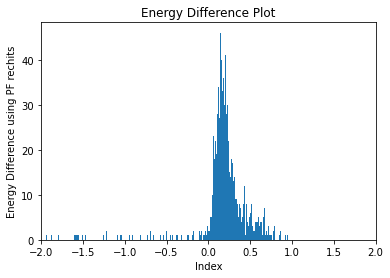

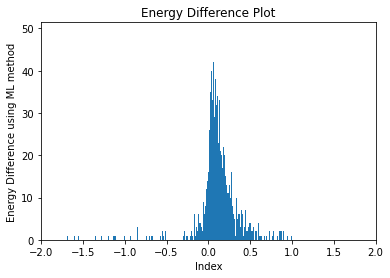

In [42]:
#### plot the diff of energy hists
# Plot the array
plt.hist(energyDiff_pf_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2   # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using PF rechits')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()


plt.hist(energyDiff_ps_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2  # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using ML method')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()

In [43]:
from scipy.stats import norm
from scipy.optimize import curve_fit

[0.80872622 0.15708723 0.08832405]


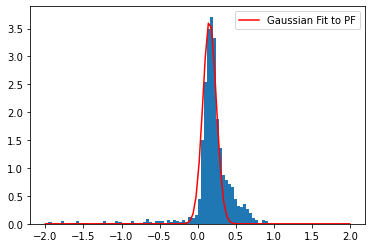

[0.80378189 0.07644079 0.09222318]


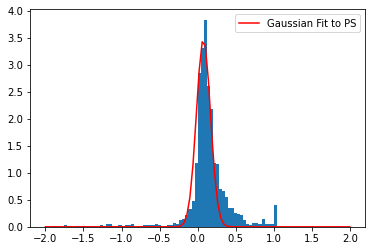

In [46]:
#### Fit both wigh Gaussian

bin_centers1, bin_edges1, _ = plt.hist(energyDiff_pf_array, bins=100, range=(-2, 2), density=True)
bin_width1 = bin_edges1[1] - bin_edges1[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers1 = bin_centers1  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
#params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)
params, _ = curve_fit(gaussian, bin_edges1[:-1], bin_centers1, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PF')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()


bin_centers, bin_edges, _ = plt.hist(energyDiff_ps_array, bins=100, range=(-2, 2), density=True)
bin_width = bin_edges[1] - bin_edges[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers = bin_centers  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PS')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()



In [47]:
bin_midpoints = [(bin_edges1[i] + bin_edges1[i + 1]) / 2 for i in range(len(bin_edges1) - 1)]
rms_value1 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers1)) / len(bin_midpoints))
rms_value2 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers)) / len(bin_midpoints))

In [48]:
rms_value1

0.17321710121140488

In [49]:
rms_value2

0.16699092515589975